# Analysis of SED Fitting ML
Idea: use the data provided in the MIRKWOOD repo and run my own ML methods on a potion of that dataset

## Preprocessing
This code is taken from MIRKWOOD, to ensure I am retrieving the data in the same way

In [1]:
import numpy as np
import pandas as pd

In [2]:
EPS = 1e-6
X_simba, y_simba = pd.read_pickle('X_simba.pkl'), pd.read_pickle('y_simba.pkl')
X_eagle, y_eagle = pd.read_pickle('X_eagle.pkl'), pd.read_pickle('y_eagle.pkl')
X_tng, y_tng = pd.read_pickle('X_tng.pkl'), pd.read_pickle('y_tng.pkl')
dataset_dict = {'simba': (X_simba, y_simba), 'eagle': (X_eagle, y_eagle), 'tng': (X_tng, y_tng)}

In [3]:
def get_data(train_data, dataset_dict=dataset_dict):
    X = pd.DataFrame()
    y = pd.DataFrame()
    for i in train_data:
        X = pd.concat((X, dataset_dict[i][0]), axis=0).reset_index().drop('index', axis=1)
        y = pd.concat((y, dataset_dict[i][1]), axis=0).reset_index().drop('index', axis=1)
    #
    #redshift = y['z'].values
    
    logmass = np.log10(y['stellar_mass'].values)
    logdustmass = np.log10(1+y['dust_mass']).values
    logmet = np.log10(y['metallicity']).values
    logsfr = np.log10(1+y['sfr'].values)
    #
    logmass[logmass<EPS] = 0
    logsfr[logsfr<EPS] = 0
    #logmet[logmet<EPS] = 0
    logdustmass[logdustmass<EPS] = 0
    return X, (logmass, logdustmass, logmet, logsfr)

## ML Methods

In [60]:
from sklearn.neural_network import MLPRegressor
from ngboost import NGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

import time
import math

Sources
- Perceptron Docs https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron
- MLPRegressor Example https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
- MLP Sklearn Overview https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression
- NGBoost library https://github.com/stanfordmlgroup/ngboost

In [152]:
X, y_total = get_data(['simba'])
data_type = 3
y = y_total[data_type]
graph_name = ""
if data_type == 0:
    graph_name = "Stellar Mass"
elif data_type == 1:
    graph_name = "Dust Mass"
elif data_type == 2:
    graph_name = "Metallicity"
elif data_type == 3:
    graph_name = "SFR"
else:
    graph_name = "UNKNOWN"

print(X.shape)

(1797, 35)


In [153]:
#Preprocessing test and training sets, for consistency
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.fit_transform(X_test)

X_norm = scaler.fit_transform(X)

In [154]:
# Multi-Layer Perceptron
mlp_time = time.time()
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train_norm, y_train)
mlp_y_pred = regr.predict(X_test_norm)

mlp_mse = mean_squared_error(mlp_y_pred, y_test)
print("MLP MSE: " + str(mlp_mse))
print("Time elapsed: " + str(time.time() - mlp_time))

MLP MSE: 0.002588513499331825
Time elapsed: 0.16452813148498535


In [155]:
ngb_time = time.time()
ngb = NGBRegressor().fit(X_train_norm, y_train)
ngb_y_pred = ngb.predict(X_test_norm)

ngb_mse = mean_squared_error(ngb_y_pred, y_test)
print("NGB MSE: " + str(ngb_mse))
print("Time elapsed: " + str(time.time()-ngb_time))

[iter 0] loss=-0.3010 val_loss=0.0000 scale=2.0000 norm=1.4181
[iter 100] loss=-1.5220 val_loss=0.0000 scale=2.0000 norm=0.8914
[iter 200] loss=-2.2660 val_loss=0.0000 scale=2.0000 norm=0.8464
[iter 300] loss=-2.7750 val_loss=0.0000 scale=2.0000 norm=0.8266
[iter 400] loss=-3.0920 val_loss=0.0000 scale=2.0000 norm=0.8399
NGB MSE: 0.002871345431448352
Time elapsed: 14.029621601104736


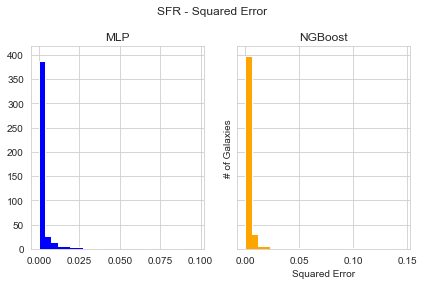

In [156]:
all_mse = [[],[]]
for i in range(len(y_test)):
    all_mse[0].append((mlp_y_pred[i]-y_test[i])**2)
    all_mse[1].append((ngb_y_pred[i]-y_test[i])**2)
#print(len(all_mse[1]))
n_bins = 25

colors = ['blue', 'orange']
labels = ['MLP', 'NGB']

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
fig.suptitle(graph_name + ' - Squared Error')

axs[0].hist(all_mse[0], n_bins, histtype='stepfilled', color=colors[0], label=labels[0])
#axs[0].legend(prop={'size': 10})
axs[0].set_title('MLP')
axs[1].hist(all_mse[1], n_bins, histtype='stepfilled', color=colors[1], label=labels[1])
#axs[1].legend(prop={'size': 10})
axs[1].set_title('NGBoost')

#plt.hist(all_mse, n_bins, histtype='bar', color=colors, label=['MLP', 'NGB'])
#plt.legend(prop={'size': 10})
plt.xlabel('Squared Error')
plt.ylabel('# of Galaxies')
plt.show()

Preliminary thoughts
- Extremely close MSE on the prediction vs test results for both
- MLP has more that are nearly completely correct, but NGB has a much tighter distribution
- Use MLP if you want more completely correct answers, and NGB if you want more nearly correct answers

<ipython-input-157-2848ba14a156>:3: RuntimeWarning: divide by zero encountered in double_scalars
  mlp_val = math.log(abs(mlp_y_pred[i]/y_test[i]),10)
<ipython-input-157-2848ba14a156>:8: RuntimeWarning: divide by zero encountered in double_scalars
  ngb_val = math.log(abs(ngb_y_pred[i]/y_test[i]),10)


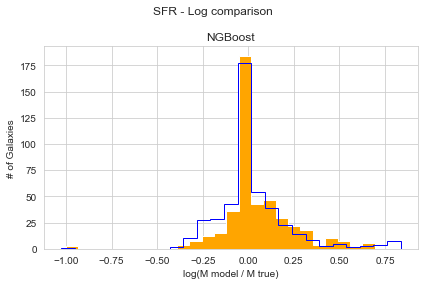

In [157]:
all_logs = [[],[]]
for i in range(len(y_test)):
    mlp_val = math.log(abs(mlp_y_pred[i]/y_test[i]),10)
    if mlp_val == math.inf:
        all_logs[0].append(0)
    else:
        all_logs[0].append(mlp_val)
    ngb_val = math.log(abs(ngb_y_pred[i]/y_test[i]),10)
    if ngb_val == math.inf:
        all_logs[1].append(0)
    else:
        all_logs[1].append(ngb_val)
#print(len(all_mse[1]))

fig, axs = plt.subplots(1, 1, sharey=True, tight_layout=True)
fig.suptitle(graph_name + ' - Log comparison')

axs.hist(all_logs[0], n_bins, histtype='step', color=colors[0], label=labels[0])
#axs[0].legend(prop={'size': 10})
axs.set_title('MLP')
axs.hist(all_logs[1], n_bins, histtype='stepfilled', color=colors[1], label=labels[1])
#axs[1].legend(prop={'size': 10})
axs.set_title('NGBoost')

#plt.hist(all_mse, n_bins, histtype='bar', color=colors, label=['MLP', 'NGB'])
#plt.legend(prop={'size': 10})
plt.xlabel('log(M model / M true)')
plt.ylabel('# of Galaxies')
plt.show()